### Important links

[reference article](https://towardsdatascience.com/predicting-future-stock-market-trends-with-python-machine-learning-2bf3f1633b3c)

[reference github](https://github.com/lucasrea/StockForecast)

### Imports

In [12]:
import yfinance as yf
import datetime
import pandas as pd
import numpy as np
from finta import TA
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, plot_confusion_matrix

from sklearn import metrics

### Constants

In [2]:
"""
Defining some constants for data mining
"""

NUM_DAYS = 10000     # The number of days of historical data to retrieve
INTERVAL = '1d'     # Sample rate of historical data
symbol = 'AMZN'      # Symbol of the desired stock

# List of symbols for technical indicators
INDICATORS = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'OBV', 'CCI', 'EMV', 'VORTEX']

[*********************100%***********************]  1 of 1 completed
                open      high       low     close  Adj Close    volume
Date                                                                   
1997-05-15  2.437500  2.500000  1.927083  1.958333   1.958333  72156000
1997-05-16  1.968750  1.979167  1.708333  1.729167   1.729167  14700000
1997-05-19  1.760417  1.770833  1.625000  1.708333   1.708333   6106800
1997-05-20  1.729167  1.750000  1.635417  1.635417   1.635417   5467200
1997-05-21  1.635417  1.645833  1.375000  1.427083   1.427083  18853200


<AxesSubplot:xlabel='Date'>

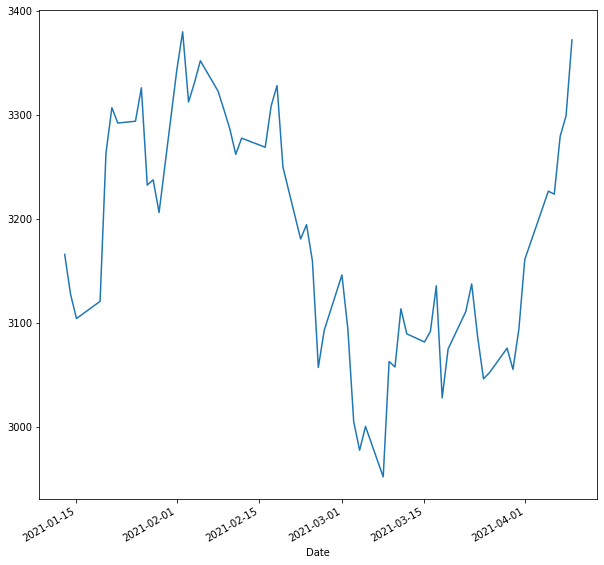

In [3]:
"""
Next we pull the historical data using yfinance
Rename the column names because finta uses the lowercase names
"""

start = (datetime.date.today() - datetime.timedelta( NUM_DAYS ) )
end = datetime.datetime.today()

data = yf.download(symbol, start=start, end=end, interval=INTERVAL)
data.rename(columns={"Close": 'close', "High": 'high', "Low": 'low', 'Volume': 'volume', 'Open': 'open'}, inplace=True)
print(data.head())

tmp = data.iloc[-60:]
plt.figure(figsize=(10,10))
tmp['close'].plot()

<AxesSubplot:xlabel='Date'>

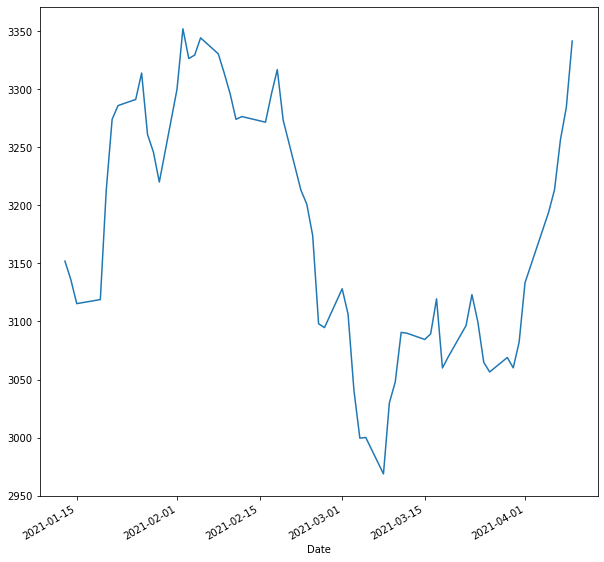

In [4]:
"""
Next we clean our data and perform feature engineering to create new technical indicator features that our
model can learn from
"""

def _exponential_smooth(df, alpha):
    """
    Function that exponentially smooths dataset so values are less 'rigid'
    :param alpha: weight factor to weight recent values more
    """
    return df.ewm(alpha=alpha).mean()

data = data.apply(_exponential_smooth, alpha = 0.65)
tmp1 = data.iloc[-60:]
plt.figure(figsize=(10,10))
tmp1['close'].plot()

In [5]:
def _get_indicator_data(data):
    """
    Function that uses the finta API to calculate technical indicators used as the features
    :return:
    """

    for indicator in INDICATORS:
        ind_data = eval('TA.' + indicator + '(data)')
        if not isinstance(ind_data, pd.DataFrame):
            ind_data = ind_data.to_frame()
        data = data.merge(ind_data, left_index=True, right_index=True)
    data.rename(columns={"14 period EMV.": '14 period EMV'}, inplace=True)

    # Also calculate moving averages for features
    data['ema50'] = data['close'] / data['close'].ewm(50).mean()
    data['ema21'] = data['close'] / data['close'].ewm(21).mean()
    data['ema15'] = data['close'] / data['close'].ewm(14).mean()
    data['ema5'] = data['close'] / data['close'].ewm(5).mean()

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    data['normVol'] = data['volume'] / data['volume'].ewm(5).mean()

    # Remove columns that won't be used as features
    del (data['open'])
    del (data['high'])
    del (data['low'])
    del (data['volume'])
    del (data['Adj Close'])
    
    return data

data = _get_indicator_data(data)
print(data.columns)

Index(['close', '14 period RSI', 'MACD', 'SIGNAL', '14 period STOCH %K', 'MFV',
       '14 period ATR', 'MOM', '14 period MFI', 'ROC', 'OBV', '20 period CCI',
       '14 period EMV', 'VIm', 'VIp', 'ema50', 'ema21', 'ema15', 'ema5',
       'normVol'],
      dtype='object')


In [6]:
live_pred_data = data.iloc[-16:-11]

In [7]:
def _produce_prediction(data, window):
    """
    Function that produces the 'truth' values
    At a given row, it looks 'window' rows ahead to see if the price increased (1) or decreased (0)
    :param window: number of days, or rows to look ahead to see what the price did
    """
    
    prediction = (data.shift(-window)['close'] >= data['close'])
    prediction = prediction.iloc[:-window]
    data['pred'] = prediction.astype(int)
    
    return data

data = _produce_prediction(data, window=7)
del (data['close'])
data = data.dropna() # Some indicators produce NaN values for the first few rows, we just remove them here
data.tail()

,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,OBV,20 period CCI,14 period EMV,VIm,VIp,ema50,ema21,ema15,ema5,normVol,pred
Date,,,,,,,,,,,,,,,,,,,,
2021-03-24,47.393178,-24.395126,-35.866677,75.604091,2.296140e+09,80.012378,51.749569,56.494934,4.408277,4.059689e+09,82.944292,155.382223,0.909356,1.081654,0.985044,0.986686,0.992998,1.002771,0.936169,1.0
2021-03-25,43.099332,-24.710203,-33.635382,57.232992,2.293635e+09,76.523714,-25.652202,58.377255,1.155874,4.056252e+09,19.503472,195.648827,0.891484,1.110416,0.974504,0.976712,0.983059,0.992936,1.003962,1.0
2021-03-26,42.105083,-25.346010,-31.977508,42.044068,2.294414e+09,72.859605,-33.327245,50.221346,0.282531,4.052899e+09,-41.015317,97.109023,0.950250,1.054154,0.972368,0.975184,0.981648,0.991830,0.982601,1.0
2021-03-29,44.161830,-24.561112,-30.494229,38.115607,2.295622e+09,69.590856,-15.532004,48.902048,-0.698731,4.055858e+09,-17.096253,52.476297,0.979154,1.032967,0.976786,0.980089,0.986594,0.996560,0.886722,1.0
2021-03-30,42.984302,-24.378145,-29.271012,30.322848,2.296234e+09,66.566915,-29.206746,42.158764,-0.964057,4.053303e+09,-20.749922,-2.619839,1.015326,1.007459,0.974444,0.978251,0.984794,0.994713,0.796907,1.0


In [8]:
def cross_Validation(data):

    # Split data into equal partitions of size len_train
    
    num_train = 10 # Increment of how many starting points (len(data) / num_train  =  number of train-test sets)
    len_train = 40 # Length of each train-test set
    
    # Lists to store the results from each model
    rf_RESULTS = []
    knn_RESULTS = []
    gbt_RESULTS = []
    ensemble_RESULTS = []
    
    i = 0
    
    # Models which will be used
    rf = RandomForestClassifier()
    knn = KNeighborsClassifier()
    
    # Create a tuple list of our models
    estimators=[('knn', knn), ('rf', rf)]
    ensemble = VotingClassifier(estimators, voting='soft')
    
    while True:
        
        # Partition the data into chunks of size len_train every num_train days
        df = data.iloc[i * num_train : (i * num_train) + len_train]
        i += 1
        #print(i * num_train, (i * num_train) + len_train)
        
        if len(df) < 40:
            break
        
        y = df['pred']
        features = [x for x in df.columns if x not in ['pred']]
        X = df[features]

        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 7 * len(X) // 10,shuffle=False)
        
        # fit models
        rf.fit(X_train, y_train)
        knn.fit(X_train, y_train)
        ensemble.fit(X_train, y_train)
        
        # get predictions
        rf_prediction = rf.predict(X_test)
        knn_prediction = knn.predict(X_test)
        ensemble_prediction = ensemble.predict(X_test)
        
#         print('rf prediction is ', rf_prediction)
#         print('knn prediction is ', knn_prediction)
#         print('ensemble prediction is ', ensemble_prediction)
#         print('truth values are ', y_test.values)
        
        # determine accuracy and append to results
        rf_accuracy = accuracy_score(y_test.values, rf_prediction)
        knn_accuracy = accuracy_score(y_test.values, knn_prediction)
        ensemble_accuracy = accuracy_score(y_test.values, ensemble_prediction)
        
#         print(rf_accuracy)
#         print(knn_accuracy)
#         print(ensemble_accuracy)
        rf_RESULTS.append(rf_accuracy)
        knn_RESULTS.append(knn_accuracy)
        ensemble_RESULTS.append(ensemble_accuracy)
                
    print('RF Accuracy = ' + str( sum(rf_RESULTS) / len(rf_RESULTS)))
    print('KNN Accuracy = ' + str( sum(knn_RESULTS) / len(knn_RESULTS)))
    print('ENSEMBLE Accuracy = ' + str( sum(ensemble_RESULTS) / len(ensemble_RESULTS)))
    
cross_Validation(data)

RF Accuracy = 0.5641778523489936
KNN Accuracy = 0.5211129753914989
ENSEMBLE Accuracy = 0.5469798657718128


In [11]:
for indicator in INDICATORS:
    ind_data = eval('TA.' + indicator + '(data)')

LookupError: Must have a dataframe column named "open"

data.apply(ewm(alpha=0.3))

In [69]:
data

In [25]:
amzn = yf.Ticker("AMZN")

In [26]:
amzn.info

{'zip': '98109-5210',
 'sector': 'Consumer Cyclical',
 'fullTimeEmployees': 1298000,
 'longBusinessSummary': 'Amazon.com, Inc. engages in the retail sale of consumer products and subscriptions in North America and internationally. The company operates through three segments: North America, International, and Amazon Web Services (AWS). It sells merchandise and content purchased for resale from third-party sellers through physical and online stores. The company also manufactures and sells electronic devices, including Kindle, Fire tablets, Fire TVs, Rings, and Echo and other devices; provides Kindle Direct Publishing, an online service that allows independent authors and publishers to make their books available in the Kindle Store; and develops and produces media content. In addition, it offers programs that enable sellers to sell their products on its websites, as well as its stores; and programs that allow authors, musicians, filmmakers, skill and app developers, and others to publish 

In [31]:
stock_df = amzn.history(period='1y', start='2019-01-01', end=None)
print(stock_df.shape)
stock_df.head()

(572, 7)


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-01-02,1465.199951,1553.359985,1460.930054,1539.130005,7983100,0,0
2019-01-03,1520.010010,1538.000000,1497.109985,1500.280029,6975600,0,0
2019-01-04,1530.000000,1594.000000,1518.310059,1575.390015,9182600,0,0
2019-01-07,1602.310059,1634.560059,1589.189941,1629.510010,7993200,0,0
2019-01-08,1664.689941,1676.609985,1616.609985,1656.579956,8881400,0,0


<AxesSubplot:xlabel='Date'>

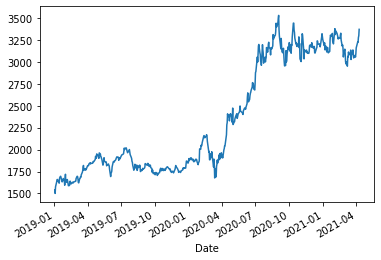

In [32]:
stock_df.Close.plot()

In [ ]:
ml